# IMPORT & SETUP

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler
from pySankey import sankey

pd.options.mode.chained_assignment = None  # default='warn'


# THE DATASET

##### Features: 
###### We see here an example entry from the dataset, we count 45 features, two of which are target features

In [10]:
file_path = 'data/train.csv' 
data = pd.read_csv(file_path)

##### Target features

In [12]:
disease_col = 'Genetic Disorder'  
subclass_col = 'Disorder Subclass'  
grouped_data = data.groupby([disease_col, subclass_col]).size().reset_index(name='Count')
num_combinations = grouped_data.shape[0]


print("Number of entries in the dataset:", len(data))

print("\nUnique Combinations of Disease and Subclass:")
grouped_data.head(10)

Number of entries in the dataset: 22083

Unique Combinations of Disease and Subclass:


,Genetic Disorder,Disorder Subclass,Count
0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,587
1,Mitochondrial genetic inheritance disorders,Leigh syndrome,4683
2,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy,3971
3,Multifactorial genetic inheritance disorders,Alzheimer's,133
4,Multifactorial genetic inheritance disorders,Cancer,91
5,Multifactorial genetic inheritance disorders,Diabetes,1653
6,Single-gene inheritance diseases,Cystic fibrosis,3145
7,Single-gene inheritance diseases,Hemochromatosis,1228
8,Single-gene inheritance diseases,Tay-Sachs,2556


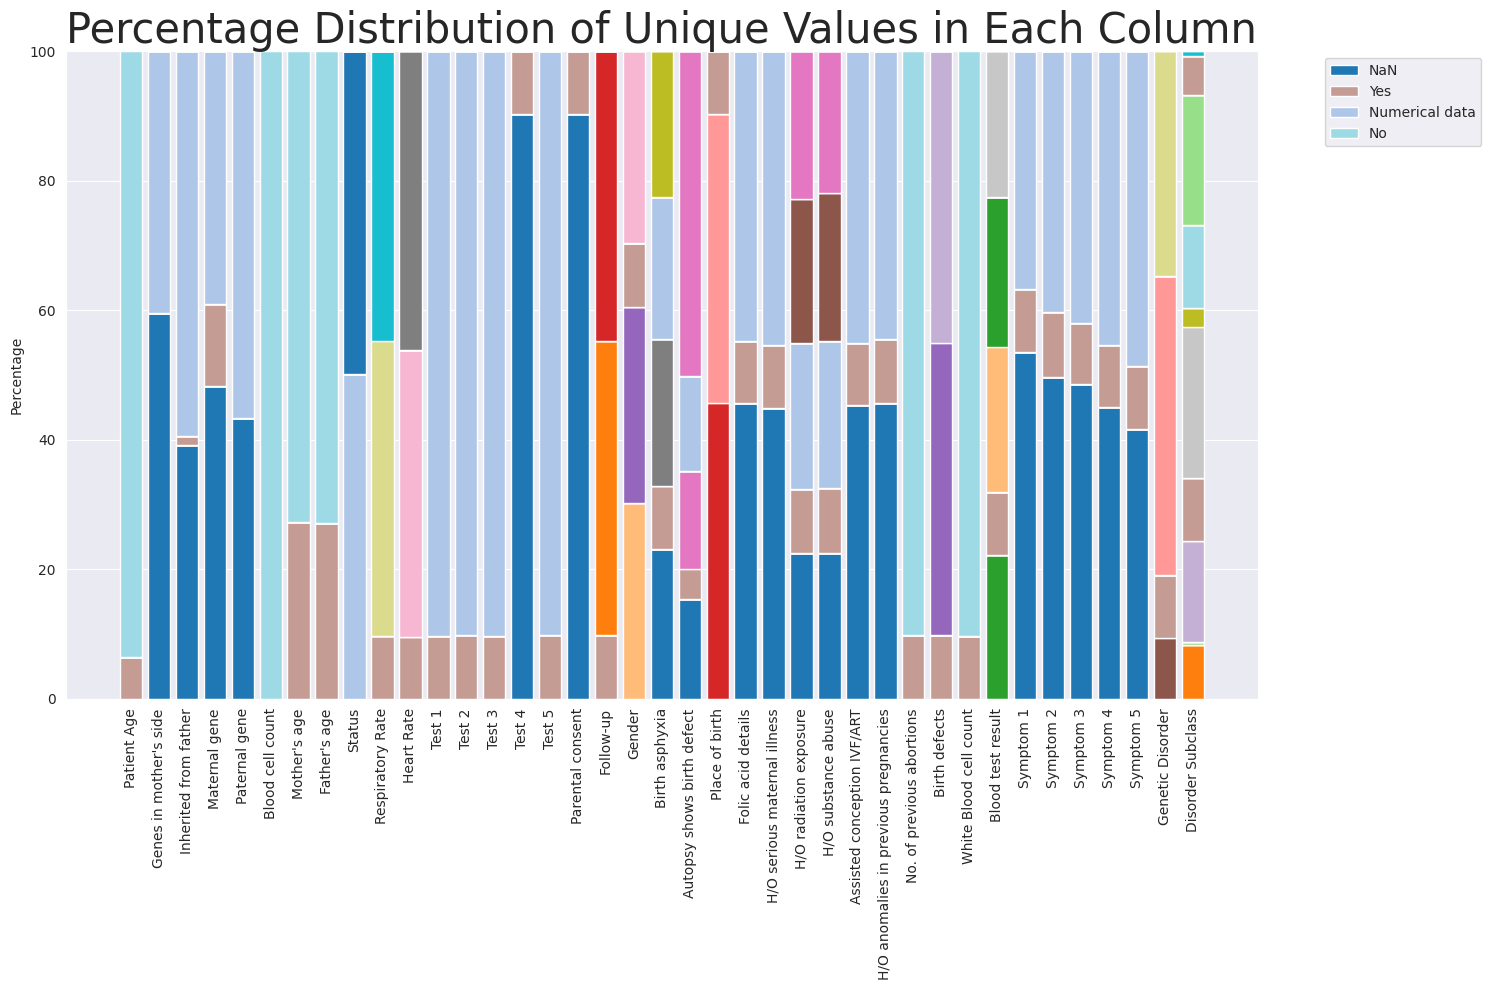

In [13]:
overview_data = data.copy()

# Drop unnecessary columns
overview_data.drop(['Patient Id', 'Institute Name', 'Location of Institute', 
                    "Father's name", 'Patient First Name', 'Family Name', 'Patient Id'], 
                    axis=1, inplace=True)

symp_test = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']
for col in symp_test:
    overview_data[col] = overview_data[col].replace({1.0:'Yes', 0.0:'No'}).fillna('NaN')

num = ['White Blood cell count (thousand per microliter)', 'No. of previous abortion', "Father's age", "Mother's age",
             'Blood cell count (mcL)', 'Patient Age' ]
for col in num:
    overview_data[col] = np.where(overview_data[col].isna(), 'NaN', 'Numerical data')

overview_data.rename(columns={'White Blood cell count (thousand per microliter)': 'White Blood cell count', 
                              'Blood cell count (mcL)':'Blood cell count', 
                              'No. of previous abortion':'No. of previous abortions',
                              'History of anomalies in previous pregnancies': 'H/O anomalies in previous pregnancies',
                              'Autopsy shows birth defect (if applicable)':'Autopsy shows birth defect',
                              'Respiratory Rate (breaths/min)':'Respiratory Rate',
                              'Heart Rate (rates/min': 'Heart Rate',
                              'Folic acid details (peri-conceptional)':'Folic acid details',
                              'H/O radiation exposure (x-ray)':'H/O radiation exposure'}, inplace=True)


# Replace actual NaN with a string 'NaN' and ensure consistent data types
for column in overview_data.columns:
    if overview_data[column].dtype == 'object':
        # Fill missing values with 'NaN' string for categorical columns
        overview_data[column] = overview_data[column].fillna('NaN')
    else:
        # Drop the column if it's not categorical and has more than 6 unique values
        if overview_data[column].nunique() > 6:
            overview_data = overview_data.drop(column, axis=1)
        else:
            # Fill numeric columns with a placeholder or an appropriate value
            overview_data[column] = overview_data[column].fillna(0)


categorical_columns = overview_data.select_dtypes(include=['object']).columns.tolist()

# Calculate the distribution percentages
percentages = {}
for column in categorical_columns:
    percentages[column] = overview_data[column].value_counts(normalize=True) * 100

# Convert the percentages to a DataFrame
percentages_df = pd.DataFrame(percentages).fillna(0).transpose()

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
cmap = plt.get_cmap("tab20")

# Get all unique values across all categorical columns
all_unique_values = set()
for column in categorical_columns:
    all_unique_values.update(overview_data[column].unique())

# Create a color dictionary for all unique values
color_dict = {value: cmap(i % 20) for i, value in enumerate(all_unique_values)}

# Plot each percentage as a stacked bar
bottom = np.zeros(len(categorical_columns))
for value in all_unique_values:
    if value in percentages_df.columns:
        ax.bar(categorical_columns, percentages_df[value], bottom=bottom, label=value, color=color_dict[value])
        bottom += percentages_df[value]




# Customize the plot
ax.set_ylabel('Percentage')
ax.set_title('Percentage Distribution of Unique Values in Each Column')
ax.title.set_size(30)
plt.xticks(rotation=90)
plt.legend(title='Unique Values', bbox_to_anchor=(1.05, 1), loc='upper left')
# Custom legend only including 'Yes', 'No', and 'NaN'
handles, labels = ax.get_legend_handles_labels()
custom_legend = [handles[i] for i, label in enumerate(labels) if label in ['NaN', 'Yes','Numerical data', 'No' ]]
ax.legend(custom_legend, ['NaN', 'Yes','Numerical data', 'No' ], title='', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
fig.savefig('overview.png', transparent=True)

###### There are 3 genetic disorders, each with 3 subclasses. 
###### We notice that there are null entries in the target features, these will not be able to controbute to the model

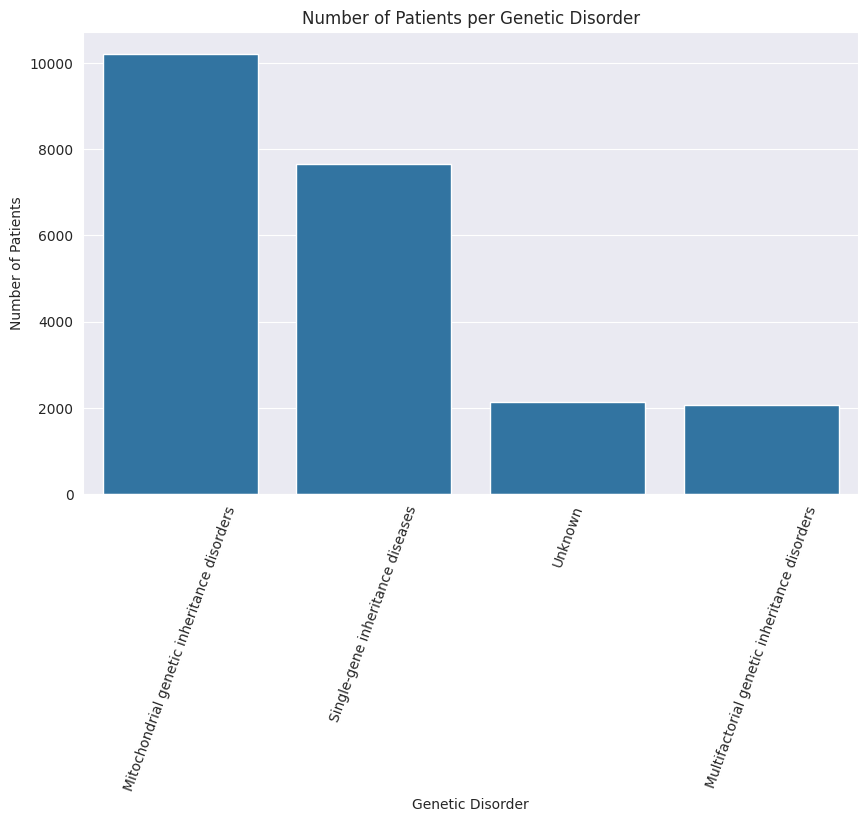

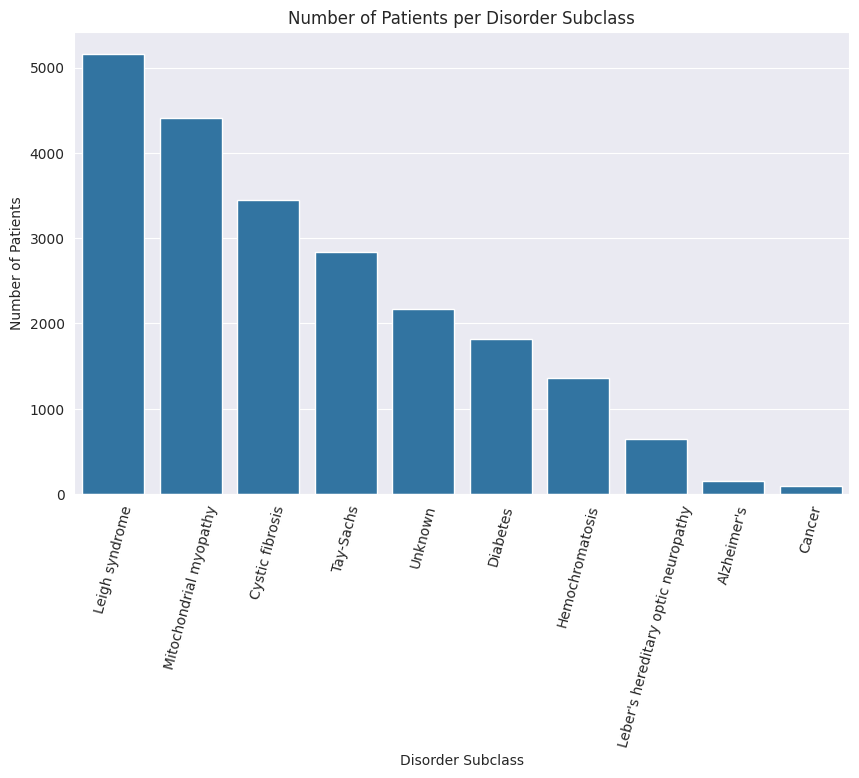

In [14]:
graph_data = data
graph_data[disease_col].fillna('Unknown', inplace=True)
graph_data[subclass_col].fillna('Unknown', inplace=True)

# Counting patients for each disease and subclass
disease_count = graph_data[disease_col].value_counts()
subclass_count = graph_data[subclass_col].value_counts()

# Plotting Bar Chart for Diseases
plt.figure(figsize=(10, 6))
sns.barplot(x=disease_count.index, y=disease_count.values) 
plt.title('Number of Patients per Genetic Disorder')
plt.ylabel('Number of Patients')
plt.xlabel('Genetic Disorder')
plt.xticks(fontsize=10, rotation=70) 
plt.show()

# Plotting Bar Chart for Subclasses
plt.figure(figsize=(10, 6))
sns.barplot(x=subclass_count.index, y=subclass_count.values)
plt.title('Number of Patients per Disorder Subclass')
plt.ylabel('Number of Patients')
plt.xlabel('Disorder Subclass')
plt.xticks(fontsize=10, rotation=75) 
plt.show()

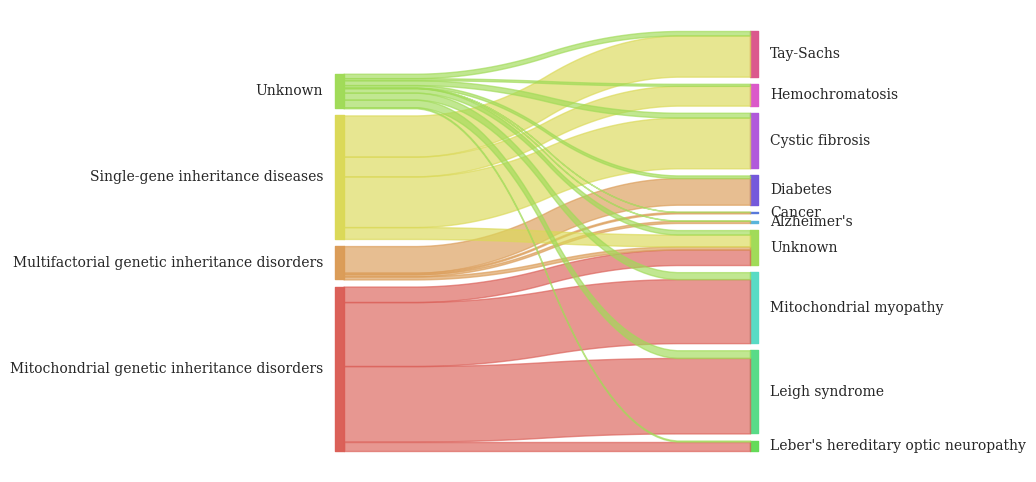

In [15]:
grouped_subclass = graph_data.groupby(["Genetic Disorder", "Disorder Subclass"], sort='Genetic Disorder',
                                      as_index=False).size()
count_class = graph_data.groupby(["Genetic Disorder"], sort='Genetic Disorder', as_index=False).size()

sankey.sankey(
    grouped_subclass["Genetic Disorder"], grouped_subclass["Disorder Subclass"], rightWeight=grouped_subclass['size'],
    leftWeight=grouped_subclass['size'], aspect=10, figure_name="Sankey for Genetic Disorder",
    fontsize=10
)


# PRE-PROCESSING

### We first start by removing all the entries where both taget features are unknown.

In [16]:
data = data.dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')

### We backfill the null values in the target features with the subclass

In [17]:
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}

data['Genetic Disorder'] = data.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']]
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)

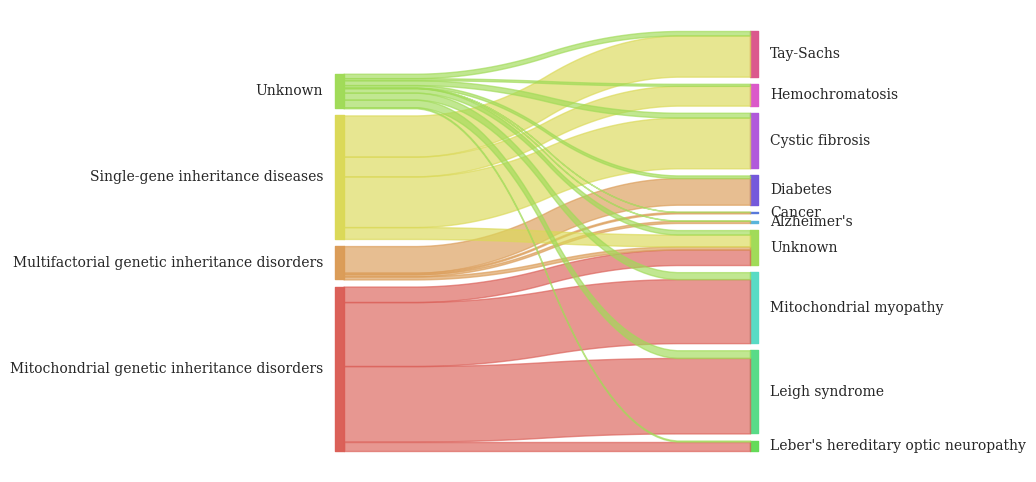

In [18]:
from pySankey import sankey

grouped_subclass = data.fillna(value={disease_col: "Unknown", subclass_col: "Unknown"}).groupby(
    ["Genetic Disorder", "Disorder Subclass"], sort='Genetic Disorder',
    as_index=False).size()
count_class = data.fillna(value={disease_col: "Unknown", subclass_col: "Unknown"}).groupby(["Genetic Disorder"],
                                                                                             sort='Genetic Disorder',
                                                                                             as_index=False).size()

sankey.sankey(
    grouped_subclass["Genetic Disorder"], grouped_subclass["Disorder Subclass"], rightWeight=grouped_subclass['size'],
    leftWeight=grouped_subclass['size'], aspect=10, figure_name="Sankey for Genetic Disorder",
    fontsize=10
)


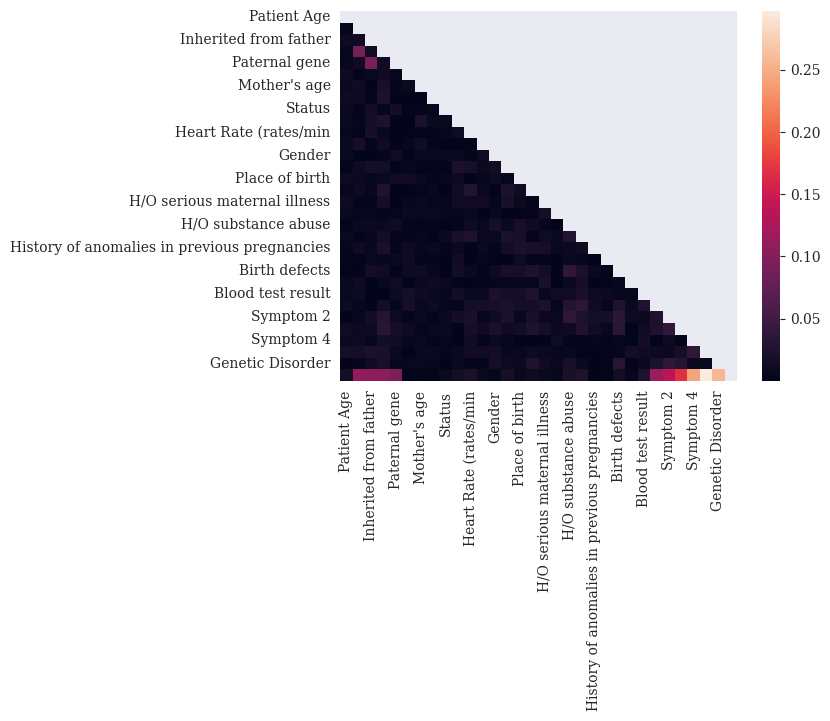

In [25]:
#  NUMERICAL --> MEDIAN IMPUTER
columns_to_drop = ['Institute Name', 'Location of Institute', "Father's name", 
                   'Patient First Name', 'Family Name', 'Patient Id', 'Parental consent', 
                'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5']
dataset = data.dropna(subset=['Genetic Disorder'], how='all')
dataset = dataset.drop(columns=columns_to_drop)

imputer = SimpleImputer(strategy='median')
dataset['Patient Age'] = imputer.fit_transform(dataset[['Patient Age']])
dataset["Mother\'s age"] = imputer.fit_transform(dataset[['Mother\'s age']])
dataset["Father\'s age"] = imputer.fit_transform(dataset[['Father\'s age']])
dataset['No. of previous abortion'] = imputer.fit_transform(dataset[['No. of previous abortion']])
dataset['White Blood cell count (thousand per microliter)'] = imputer.fit_transform(dataset[['White Blood cell count (thousand per microliter)']])


# SCALE
robust_scaler = RobustScaler()
dataset['White Blood cell count (thousand per microliter)'] = robust_scaler.fit_transform(dataset[['White Blood cell count (thousand per microliter)']])
dataset['Blood cell count (mcL)'] = robust_scaler.fit_transform(dataset[['Blood cell count (mcL)']])
dataset['No. of previous abortion'] = robust_scaler.fit_transform(dataset[['No. of previous abortion']])




# CATEGORIAL BINARY
mode_imputer = SimpleImputer(strategy='most_frequent')
dataset['Autopsy shows birth defect (if applicable)'] = dataset['Autopsy shows birth defect (if applicable)'].replace({'Yes': 1.0, 'No': 0.0, 'Not applicable': 0.0}).fillna(0.0)
#dataset['Parental consent'] = dataset['Parental consent'].replace('Yes', 1.0).fillna(0.0)
dataset['H/O substance abuse'] = dataset['H/O substance abuse'].replace({'No': 0.0, 'Yes':1.0, 'Not applicable':0.0, '-':0.0}).fillna(-1.0)
dataset['Inherited from father'] = dataset['Inherited from father'].replace({'No': 0.0, 'Yes':1.0}).fillna(-1.0)
dataset['Maternal gene'] = dataset['Maternal gene'].replace({'No': 0.0, 'Yes':1.0}).fillna(0.0)
dataset['History of anomalies in previous pregnancies'] = dataset['History of anomalies in previous pregnancies'].replace({'Yes': 1.0, 'No': 0.0}).fillna(0.0)
dataset['H/O serious maternal illness'] = dataset['H/O serious maternal illness'].replace({'Yes': 1.0, 'No': 0.0}).fillna(0.0)
dataset['H/O radiation exposure (x-ray)'] = dataset['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 0.0, 'Not applicable': 0.0, 'Yes':1.0}).fillna(0.0)

dataset['Place of birth'] = dataset['Place of birth'].replace({'Institute': 1.0, 'Home': 0.0})
dataset['Place of birth'] = mode_imputer.fit_transform(dataset[['Place of birth']])
# NaN non imputed --> -1.0
dataset['Birth asphyxia'] = dataset['Birth asphyxia'].replace({'No': 0.0, 'No record': 0.0, 'Not available': -1.0, 'Yes':1.0}).fillna(-1.0)

dataset['Respiratory Rate (breaths/min)'] = dataset['Respiratory Rate (breaths/min)'].replace({'Normal (30-60)': 0.0, 'Tachypnea': 1.0})
dataset['Respiratory Rate (breaths/min)'] = mode_imputer.fit_transform(dataset[['Respiratory Rate (breaths/min)']]) 

dataset['Heart Rate (rates/min'] = dataset['Heart Rate (rates/min'].replace({'Normal': 0.0, 'Tachycardia': 1.0})
dataset['Heart Rate (rates/min'] = mode_imputer.fit_transform(dataset[['Heart Rate (rates/min']])
dataset['Follow-up'] = dataset['Follow-up'].replace({'High': 1.0, 'Low': 0.0})
dataset['Follow-up'] = mode_imputer.fit_transform(dataset[['Follow-up']])

dataset['Folic acid details (peri-conceptional)'] = dataset['Folic acid details (peri-conceptional)'].replace({'Yes': 1.0, 'No': 0.0}).fillna(-1.0)
dataset['Assisted conception IVF/ART'] = dataset['Assisted conception IVF/ART'].replace({'Yes': 1.0, 'No': 0.0}).fillna(-1.0)
dataset['Birth defects'] = dataset['Birth defects'].replace({'Multiple': 1.0, 'Singular': 0.0}).fillna(-1.0)

# CATEGORIAL MULTICLASS
dataset['Gender'] = dataset['Gender'].replace({'Male': 1.0, 'Female': 0.0, 'Ambiguous': 2.0}).fillna(2.0)
dataset['Gender'] = robust_scaler.fit_transform(dataset[['Gender']])
dataset['Blood test result'] = dataset['Blood test result'].replace({'normal': 0.0, 'inconclusive': -1.0, 'slightly abnormal': 0.5, 'abnormal': 1.0}).fillna(-1.0)
dataset['Blood test result'] = robust_scaler.fit_transform(dataset[['Blood test result']])

# BINARY FEATURES WITH NO NaN
dataset["Genes in mother's side"] = dataset["Genes in mother's side"].replace({'Yes': 1.0, 'No': 0.0})
dataset["Paternal gene"] = dataset["Paternal gene"].replace({'Yes': 1.0, 'No': 0.0})
dataset["Status"] = dataset["Status"].replace({'Alive': 0.0, 'Deceased': 1.0})

dataset['Symptom 1'] = dataset['Symptom 1'].fillna(-1.0)
dataset['Symptom 2'] = dataset['Symptom 2'].fillna(-1.0)
dataset['Symptom 3'] = dataset['Symptom 3'].fillna(-1.0)
dataset['Symptom 4'] = dataset['Symptom 4']
dataset['Symptom 5'] = dataset['Symptom 5']
dataset = dataset.dropna(subset=['Symptom 4', 'Symptom 5'])


#-------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#

label_encoder = LabelEncoder()
heat_data = dataset.copy()
heat_data['Genetic Disorder'] = label_encoder.fit_transform(heat_data['Genetic Disorder'])
heat_data['Disorder Subclass'] = label_encoder.fit_transform(heat_data['Disorder Subclass'])

corr = heat_data.corr(numeric_only=True).applymap(lambda x: abs(x))
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=False)
plt.show()

In [26]:

features_used = ['Inherited from father', 'Maternal gene', 'Paternal gene', 'Genes in mother\'s side', 'Symptom 1',
                 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']
targets = ['Genetic Disorder', 'Disorder Subclass']

dataset = data.loc[:, features_used + targets].dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')
# Fill missing values in 'Genetic Disorder' based on 'Disorder Subclass'
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}

dataset['Genetic Disorder'] = dataset.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']]
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)
# dataset = dataset.drop(['Disorder Subclass'], axis=1)
dataset = dataset.dropna(subset=['Genetic Disorder'], how='all')

# CATEGORIAL BINARY
dataset["Genes in mother's side"] = dataset["Genes in mother's side"].replace({'Yes': 1.0, 'No': -1.0})
dataset['Inherited from father'] = dataset['Inherited from father'].replace({'No': -1.0, 'Yes': 1.0})
dataset['Maternal gene'] = dataset['Maternal gene'].replace({'No': -1.0, 'Yes': 1.0})
dataset["Paternal gene"] = dataset["Paternal gene"].replace({'Yes': 1.0, 'No': -1.0})

dataset[['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']] = dataset[['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']].fillna(-1)
dataset = dataset.dropna(subset=['Symptom 4', 'Symptom 5'])
# -------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#
genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': 1,
    'Multifactorial genetic inheritance disorders': 0,
    'Single-gene inheritance diseases': 2,
}
dataset['Genetic Disorder'] = dataset['Genetic Disorder'].map(genetic_disorder_mapping)

disorder_subclass_mapping = {
    "Leber's hereditary optic neuropathy": 0,
    'Cystic fibrosis': 1,
    'Diabetes': 2,
    'Leigh syndrome': 3,
    'Tay-Sachs': 4,
    'Mitochondrial myopathy': 5,
    'Hemochromatosis': 6,
    "Alzheimer's": 7,
    'Cancer': 8,
}
dataset['Disorder Subclass'] = dataset['Disorder Subclass'].map(disorder_subclass_mapping)
heat_data = dataset.dropna()

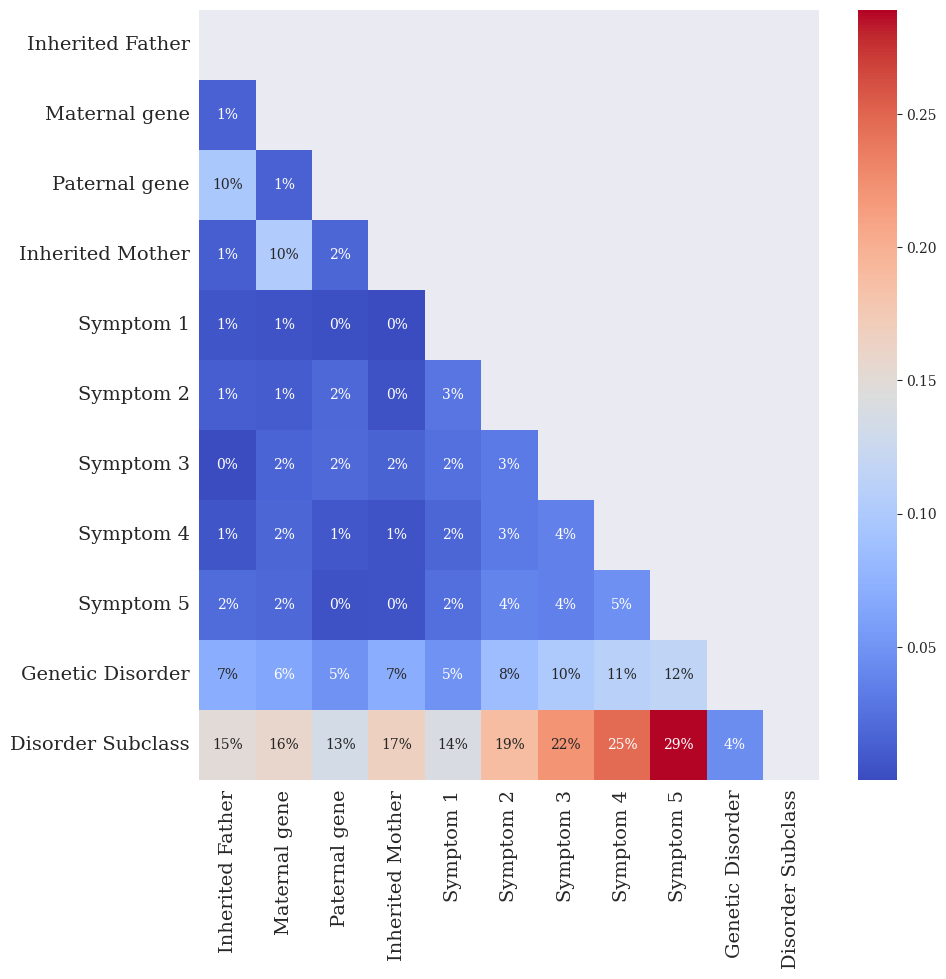

In [27]:
corr = heat_data.corr().applymap(lambda x: abs(x)).rename(
    {'Inherited from father': 'Inherited Father', 'Genes in mother\'s side': 'Inherited Mother'})
plt.figure(figsize=(10, 10))
matrix = np.triu(corr)

sns.heatmap(
    corr.rename({'Inherited from father': 'Inherited Father', 'Genes in mother\'s side': 'Inherited Mother'}, axis=1),
    annot=True, fmt=".0%", cmap='coolwarm', mask=matrix)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)
# plt.title('Correlation Between Important Features', fontsize=35)
# plt.show()
plt.savefig('correlation.png', transparent=True, bbox_inches='tight')